# TD4 - Explainability AI

#### Matias OTTENSEN
#### Tiphaine KACHKACHI
#### Manon GARDIN

# Our dataset 

Petite description du dataset

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn
from sklearn.datasets import load_diabetes

In [216]:
df = pd.read_csv('archive/US_Accidents_March23.csv', sep=',')

## Observe data

In [81]:
df.shape

(7728394, 46)

We have a great number of lines in our dataset.\
Also we have 46 columns, we probably won't need every one of them. Let's see their name :

In [82]:
df.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [5]:
df.head(10)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

As the dataframe is huge (almost 3 gb), we decided to work on another version of this dataframe, just to have a sample that we could work on esier:

Variables like Street, City, Zipcode and County won't be useful to keep, because there are too many distinct values.\
The columns Bump, Traffic_calming, Turning_loop, Give_Way, No_Exit, Roundabout can be deleted because they take only one value (all false).\
The variable Country only takes US so we can delete it.\
We can also delete some columns like Airport_Code that won't be relevant.

In [217]:
# Delete the columns we don't need 
df = df.drop(['Street', 'City', 'Description','County', 'Zipcode', 'Country', 'Bump', 'Traffic_Calming', 'Turning_Loop', 'Give_Way', 'No_Exit', 'Roundabout', 'Airport_Code'], axis=1)

In [85]:
df.head(10)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,False,True,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,False,True,Day,Day,Day,Day
5,A-6,Source2,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,Source2,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,Source2,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,Source2,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,Source2,3,2016-02-08 08:10:04,2016-02-08 08:40:04,40.100590,-82.925194,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


In [8]:
df.describe

<bound method NDFrame.describe of                 ID   Source  Severity           Start_Time  \
0              A-1  Source2         3  2016-02-08 05:46:00   
1              A-2  Source2         2  2016-02-08 06:07:59   
2              A-3  Source2         2  2016-02-08 06:49:27   
3              A-4  Source2         3  2016-02-08 07:23:34   
4              A-5  Source2         2  2016-02-08 07:39:07   
...            ...      ...       ...                  ...   
7728389  A-7777757  Source1         2  2019-08-23 18:03:25   
7728390  A-7777758  Source1         2  2019-08-23 19:11:30   
7728391  A-7777759  Source1         2  2019-08-23 19:00:21   
7728392  A-7777760  Source1         2  2019-08-23 19:00:21   
7728393  A-7777761  Source1         2  2019-08-23 18:52:06   

                    End_Time  Start_Lat   Start_Lng   End_Lat    End_Lng  \
0        2016-02-08 11:00:00  39.865147  -84.058723       NaN        NaN   
1        2016-02-08 06:37:59  39.928059  -82.831184       NaN        

# Data Cleaning

Missing values:

In [86]:
print(df.isnull().sum())

ID                            0
Source                        0
Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
End_Lat                  772839
End_Lng                  772839
Distance(mi)                  0
State                         0
Timezone                    262
Weather_Timestamp          7182
Temperature(F)            11731
Wind_Chill(F)            455716
Humidity(%)               12770
Pressure(in)               9344
Visibility(mi)            15302
Wind_Direction             9179
Wind_Speed(mph)           96007
Precipitation(in)        467302
Weather_Condition         14444
Amenity                       0
Crossing                      0
Junction                      0
Railway                       0
Station                       0
Stop                          0
Traffic_Signal                0
Sunrise_Sunset             1631
Civil_Twilight             1631
Nautical

There are missing values, so, what can we do about it?

First, we create a new dataframe to secure the first one if we ever delete the wring values

In [218]:
newdf = df

We had to make a choice for each column on how to handle the missing values. We chose to keep every missing values, we did not delete any rows. We preferred to replace them with values that are easily readable for string values, and to use the average for the numerical values.

In [219]:
#for the end lat/lng : we will fill the NAN by the start lat/lng:

newdf['End_Lat']=newdf['End_Lat'].fillna(newdf['Start_Lat'])
newdf['End_Lng']=newdf['End_Lng'].fillna(newdf['Start_Lng'])

#for the streets/Cities/Description/timezone/Weather_Condition/Sunrise_Sunset/Civil_Twilight/Nautical_Twilight
#and Astronomical_Twilight, we just write "unknown", 
#as we do not want to give fake informations to the person reading

newdf['Timezone']=newdf['Timezone'].fillna('unknown')
newdf['Weather_Condition']=newdf['Weather_Condition'].fillna('unknown')
newdf['Sunrise_Sunset']=newdf['Sunrise_Sunset'].fillna('unknown')
newdf['Civil_Twilight']=newdf['Civil_Twilight'].fillna('unknown')
newdf['Nautical_Twilight']=newdf['Weather_Condition'].fillna('unknown')
newdf['Astronomical_Twilight']=newdf['Astronomical_Twilight'].fillna('unknown')

# for the weather timestamp, we put now's date
newdf['Weather_Timestamp']=newdf['Weather_Timestamp'].fillna(datetime.now())

newdf = newdf.dropna(subset=['Precipitation(in)'])
newdf = newdf.dropna(subset=['Temperature(F)'])
newdf = newdf.dropna(subset=['Wind_Chill(F)'])
newdf = newdf.dropna(subset=['Pressure(in)'])
newdf = newdf.dropna(subset=['Humidity(%)'])
newdf = newdf.dropna(subset=['Visibility(mi)'])
newdf = newdf.dropna(subset=['Wind_Speed(mph)'])

# for the airport code, we write '###' in the missing values
newdf['Wind_Direction']=newdf['Wind_Direction'].fillna('###')

In [201]:
print(newdf.isnull().sum())

ID                       0
Source                   0
Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
State                    0
Timezone                 0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Crossing                 0
Junction                 0
Railway                  0
Station                  0
Stop                     0
Traffic_Signal           0
Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
Astronomical_Twilight    0
dtype: int64


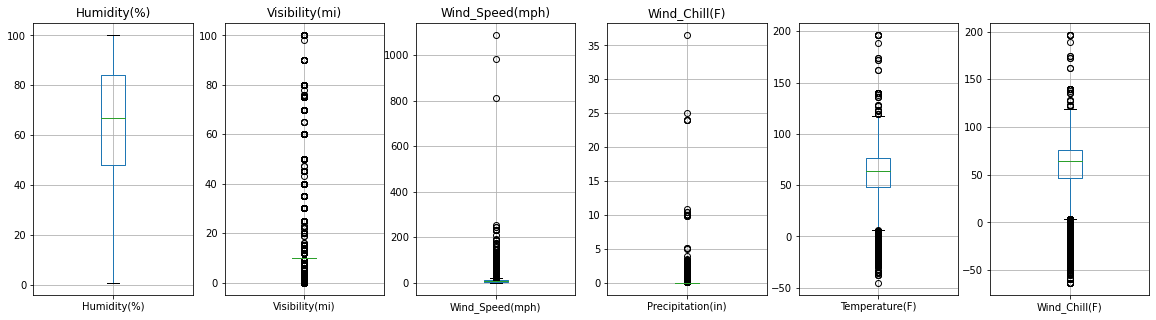

In [209]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

newdf[['Humidity(%)']].boxplot(ax=axes[0])
axes[0].set_title('Humidity(%)')

newdf[['Visibility(mi)']].boxplot(ax=axes[1])
axes[1].set_title('Visibility(mi)')

newdf[['Wind_Speed(mph)']].boxplot(ax=axes[2])
axes[2].set_title('Wind_Speed(mph)')

newdf[['Precipitation(in)']].boxplot(ax=axes[3])
axes[3].set_title('Precipitation(in)')

newdf[['Temperature(F)']].boxplot(ax=axes[4])
axes[3].set_title('Temperature(F)')

newdf[['Wind_Chill(F)']].boxplot(ax=axes[5])
axes[3].set_title('Wind_Chill(F)')

plt.show()

as we can see, there are a lot of outliers in the dataset, we chose to keep a certain amount of them, and to delete the rest.

As we can see for example in the visibility plot, there is a huge amount of "10" values, so the other values are more rare, so we can decide to keep it this way or to delete them. We chose not to delete everyone of them.

In [220]:
#Visibility 
newdf.loc[newdf['Visibility(mi)'] > 60, 'Visibility(mi)'] = 60

#Wind speed
newdf = newdf[newdf['Wind_Speed(mph)'] <= 400]

#precipitaion
newdf = newdf[newdf['Precipitation(in)'] <= 7]

#Temperature
Q1= newdf['Temperature(F)'].quantile(0.25)
Q3= newdf['Temperature(F)'].quantile(0.75)
IQR = Q3 - Q1

max_limit = Q3 + (1.5 * IQR)
min_limit = Q1 - (1.5 * IQR)

newdf.loc[(df['Temperature(F)'] < min_limit), 'Temperature(F)'] = min_limit
newdf.loc[(df['Temperature(F)'] > max_limit), 'Temperature(F)'] = max_limit

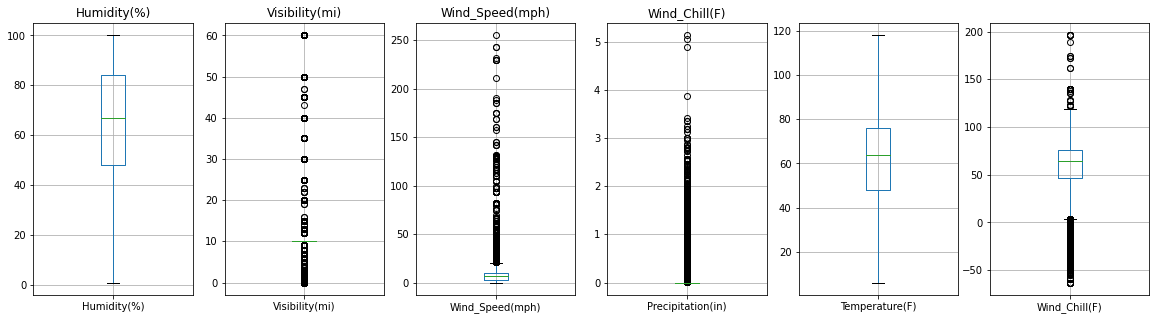

In [221]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))

newdf[['Humidity(%)']].boxplot(ax=axes[0])
axes[0].set_title('Humidity(%)')

newdf[['Visibility(mi)']].boxplot(ax=axes[1])
axes[1].set_title('Visibility(mi)')

newdf[['Wind_Speed(mph)']].boxplot(ax=axes[2])
axes[2].set_title('Wind_Speed(mph)')

newdf[['Precipitation(in)']].boxplot(ax=axes[3])
axes[3].set_title('Precipitation(in)')

newdf[['Temperature(F)']].boxplot(ax=axes[4])
axes[3].set_title('Temperature(F)')

newdf[['Wind_Chill(F)']].boxplot(ax=axes[5])
axes[3].set_title('Wind_Chill(F)')

plt.show()

In [222]:
halfsize=int((newdf.shape[0])/80)
newdf = newdf.iloc[:halfsize,:]
print(newdf.shape)
newdf.reset_index(drop=True, inplace=True)

(65584, 33)


In [223]:
print(newdf['Precipitation(in)'])

0        0.03
1        0.02
2        0.02
3        0.02
4        0.01
         ... 
65579    0.00
65580    0.00
65581    0.00
65582    0.00
65583    0.00
Name: Precipitation(in), Length: 65584, dtype: float64


# Question 3

The variables we can predict are probably the severity of an accident, and maybe a start time.

Based on our intuition, we think that the most important variables to predict the severity of an accident would be the weather condition variables like Humidity, Wind Speed, Pressure, etc. And probably the time of the day like Day or Night.

## Univariate Analysis

Let's do a histogram

(array([16927.,     0.,     0., 25157.,     0.,     0., 23171.,     0.,
            0.,   329.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

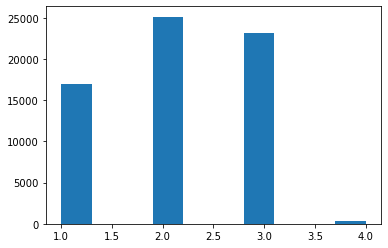

In [224]:
plt.hist(newdf['Severity'])

(array([50460.,     0.,     0.,     0.,     0., 14760.,     0.,     0.,
            0.,   364.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

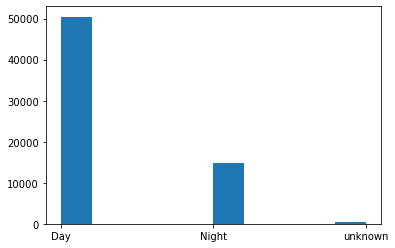

In [225]:
plt.hist(newdf['Sunrise_Sunset'])

(array([  192.,  1209.,  2256.,  3587.,  5660.,  7079.,  8292.,  9607.,
        14489., 13213.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

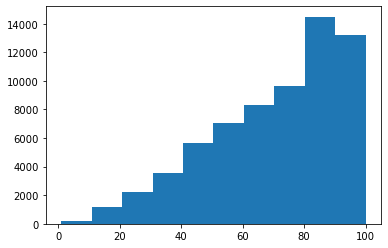

In [226]:
plt.hist(newdf['Humidity(%)'])

(array([2.7000e+01, 7.2500e+02, 9.4100e+02, 1.4690e+03, 6.0432e+04,
        1.9890e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([20.98 , 22.827, 24.674, 26.521, 28.368, 30.215, 32.062, 33.909,
        35.756, 37.603, 39.45 ]),
 <BarContainer object of 10 artists>)

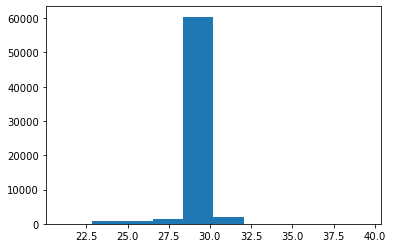

In [227]:
plt.hist(newdf['Pressure(in)'])

As we can see, in most case, there is high humidity, more, accidents with 0% humidity are very rare according to the histogram.
Most accidents happen with 7.5 mph, during the day, with a 30/35 in of pressure.

## Bivariate Analysis

Let's do some correlation matrices to understand which variables are the most impactful on the severity.

<AxesSubplot:>

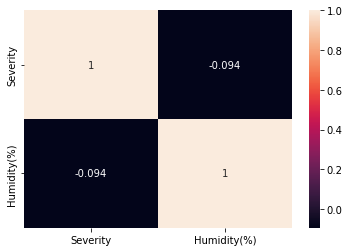

In [228]:
correl1 = newdf.loc[:, ['Severity', 'Humidity(%)']]
corr_matrix = correl1.corr()
sns.heatmap(corr_matrix, annot=True)

<AxesSubplot:>

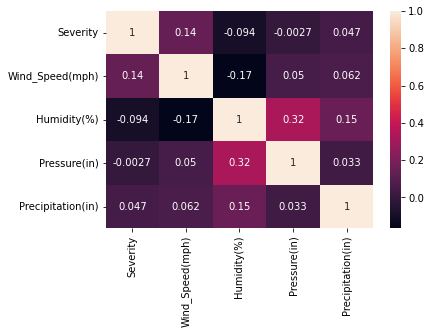

In [229]:
correl1 = newdf.loc[:, ['Severity', 'Wind_Speed(mph)','Humidity(%)','Pressure(in)', 'Precipitation(in)']]
corr_matrix = correl1.corr()
sns.heatmap(corr_matrix, annot=True)

So we can here see the correlation between the severity and the other chosen quantitative variable. The highest are the precipitation and the wind speed.

# Question 4

Here we are going to do a linear regression to predict values of new data for the dataset. 
Based on our intuition, we think that the most important variables to predict the severity of an accident would be the weather condition variables like Humidity or the time of the day like Day or Night, or even where it happened (what is on a stop, or a traffic sign ?)...


In [230]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [231]:
newdf.info() #We check again which colomns we have and their type 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65584 entries, 0 to 65583
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     65584 non-null  object 
 1   Source                 65584 non-null  object 
 2   Severity               65584 non-null  int64  
 3   Start_Time             65584 non-null  object 
 4   End_Time               65584 non-null  object 
 5   Start_Lat              65584 non-null  float64
 6   Start_Lng              65584 non-null  float64
 7   End_Lat                65584 non-null  float64
 8   End_Lng                65584 non-null  float64
 9   Distance(mi)           65584 non-null  float64
 10  State                  65584 non-null  object 
 11  Timezone               65584 non-null  object 
 12  Weather_Timestamp      65584 non-null  object 
 13  Temperature(F)         65584 non-null  float64
 14  Wind_Chill(F)          65584 non-null  float64
 15  Hu

In [232]:
# Define target variable and predictor variables
X = newdf[['Visibility(mi)','Weather_Condition','Crossing','Junction','Station','Traffic_Signal','Stop','State','Precipitation(in)']] 
y = newdf['Severity']

After many test, to see which variables we should tale we decided to go with variable containing location informations (stop, state, traffic_signal...), variables linked to the condition (visibility, weather condition...).

In [233]:
# hot encoding on 'Weather_Condition' and 'State' columns as they are string colomns
X_encoded = pd.get_dummies(X, columns=['Weather_Condition','State'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [234]:
# Fit the linear regression model on the encoded data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [235]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print("Training R^2 score:", train_score)
print("Testing R^2 score:", test_score)

# Where a higher value indicates a better fit of the model to the data.

Training R^2 score: 0.24226888003767233
Testing R^2 score: 0.23505604310304584


We got a Training R^2 score of around 0.09004. Knowing that the training R^2 score measures how well the model fits the training data. A high training R^2 score indicates that the model explains a large proportion of the variance in the training data. 

The testing R^2 score measures how well the model generalizes to new, unseen data. This is crucial because the ultimate goal of a machine learning model is to make accurate predictions on new data. Here we have a higher testing score then a training score, while still behind close in value. Having a much higher testing score indicates overfitting.

Like we said earlier we tested the model with many differents variables to see which had the biggest impact on the dataset, and this is the combination that made us have the highest score for both the training and the testing score. Still, the number for both training and testing are very low (as it variates between 0 and 1). This may indicated us that the model is underfitting, meaning it's too simplistic. We can deduce that it's not explaining much of the variance in the data overall, this may be because there are so many variables, they don't have much significance overall on the dataset...

In [236]:
#Now we can get the coefficients
coefficients = model.coef_
intercept = model.intercept_

In [237]:
# Here we display all coefficients 
print("Intercept:", intercept)
for i, variable in enumerate(X_encoded.columns):
    print(f"Coefficient for {variable}: {coefficients[i]}")

Intercept: 1.9873310015014378
Coefficient for Visibility(mi): 0.008294440440956842
Coefficient for Crossing: -0.2413586311139913
Coefficient for Junction: 0.2126979341212098
Coefficient for Station: -0.26108284820183714
Coefficient for Traffic_Signal: -0.4291494690693934
Coefficient for Stop: -0.4745263709630324
Coefficient for Precipitation(in): 0.07488218293121635
Coefficient for Weather_Condition_Blowing Snow: -0.03326801309390123
Coefficient for Weather_Condition_Clear: 0.44773551453778115
Coefficient for Weather_Condition_Cloudy: 0.1572148686192273
Coefficient for Weather_Condition_Cloudy / Windy: 0.06547604810595048
Coefficient for Weather_Condition_Drizzle: 0.2573572132482987
Coefficient for Weather_Condition_Drizzle and Fog: -3.835820550079916e-14
Coefficient for Weather_Condition_Fair: 0.12263446384405466
Coefficient for Weather_Condition_Fair / Windy: 0.25195648801309994
Coefficient for Weather_Condition_Fog: 0.04611991497111953
Coefficient for Weather_Condition_Haze: 0.30118

Our intercept value is of 2.14 approximatly. This means when all of our independent variables are zero, the model predicts that the value of the Severity will be around 2.13. 

As we can see, there are so many variables, all of the coefficients are, in the end, very low. A coefficient close to zero suggests that the presence or absence of drifting snow as a weather condition has almost no impact on the Severity of accidents. 
As there are many coefficient, to see a little bit better we can display only the one that interest us by choosing value bigger then a number, like so :

In [238]:
# We display all coefficients with a high number = high impact on Severity
print("Intercept:", intercept)
for i, variable in enumerate(X_encoded.columns):
    if abs(coefficients[i]) > 0.5:
        print(f"Coefficient for {variable}: {coefficients[i]}")

Intercept: 1.9873310015014378
Coefficient for Weather_Condition_Heavy Drizzle: 0.6184802621309053
Coefficient for Weather_Condition_Heavy Ice Pellets: 0.9461044564477967
Coefficient for Weather_Condition_Heavy Snow: 0.534655702528676
Coefficient for Weather_Condition_Ice Pellets: 0.5033501619148105
Coefficient for Weather_Condition_Light Freezing Drizzle: 0.5504535628925026
Coefficient for Weather_Condition_Light Freezing Fog: 0.7190285534804703
Coefficient for Weather_Condition_Light Freezing Rain: 0.5410180387365844
Coefficient for Weather_Condition_Light Ice Pellets: 0.6747075055925827
Coefficient for Weather_Condition_Light Rain Showers: 0.5026463746962562
Coefficient for Weather_Condition_Light Rain with Thunder: 0.5176337179860939
Coefficient for Weather_Condition_Light Thunderstorms and Rain: 0.5908249583612543
Coefficient for Weather_Condition_Light Thunderstorms and Snow: 1.1013484515702154
Coefficient for Weather_Condition_Snow: 0.503270629672161
Coefficient for Weather_Condi

As we can see, all bad weather condition have a very positive impact on the Severity of the Accident. Precipitation have a huge impact, which is surprising because we would have though the visibility would be more important. 

Either then precipitation, only some weather condition have a big impact (like duststormn, blowing snow).

In [239]:
# We display all coefficient with a low number = low impact on Severity
for i, variable in enumerate(X_encoded.columns):
    if abs(coefficients[i]) < 0.1:
        print(f"Coefficient for {variable}: {coefficients[i]}")

Coefficient for Visibility(mi): 0.008294440440956842
Coefficient for Precipitation(in): 0.07488218293121635
Coefficient for Weather_Condition_Blowing Snow: -0.03326801309390123
Coefficient for Weather_Condition_Cloudy / Windy: 0.06547604810595048
Coefficient for Weather_Condition_Drizzle and Fog: -3.835820550079916e-14
Coefficient for Weather_Condition_Fog: 0.04611991497111953
Coefficient for Weather_Condition_Heavy Freezing Rain: -0.07211461236382544
Coefficient for Weather_Condition_Heavy Thunderstorms and Snow: -6.654399253847032e-15
Coefficient for Weather_Condition_Light Snow / Windy: -3.0461744238152733e-15
Coefficient for Weather_Condition_Mist: 0.08382005690429328
Coefficient for Weather_Condition_Shallow Fog: 0.051363793631666425
Coefficient for State_AR: -0.06676862256373117
Coefficient for State_AZ: -0.0701625378049201
Coefficient for State_CA: -0.045392084610575256
Coefficient for State_ID: -1.1102230246251565e-15
Coefficient for State_IL: 0.09659965137906797
Coefficient fo

The results are a bit surprising as we could think visibility could have a bigger impact on the Severity, however it is not the case. A lot of weather condition also have a low impact, but this could be because there is not enought data with all these types of weather. As we can see above, weather does have an impact on the severity. 
We would have also though that Crossing, Junction and Station had bigger coefficient overall. 

It could be interesting to see which coefficients have a medium impact (between 0.1 and 0.5).

In [240]:
# We display all coefficient with a medium number = mldium impact on Severity
for i, variable in enumerate(X_encoded.columns):
    if 0.1 <= abs(coefficients[i]) <= 0.5:
        print(f"Coefficient for {variable}: {coefficients[i]}")

Coefficient for Crossing: -0.2413586311139913
Coefficient for Junction: 0.2126979341212098
Coefficient for Station: -0.26108284820183714
Coefficient for Traffic_Signal: -0.4291494690693934
Coefficient for Stop: -0.4745263709630324
Coefficient for Weather_Condition_Clear: 0.44773551453778115
Coefficient for Weather_Condition_Cloudy: 0.1572148686192273
Coefficient for Weather_Condition_Drizzle: 0.2573572132482987
Coefficient for Weather_Condition_Fair: 0.12263446384405466
Coefficient for Weather_Condition_Fair / Windy: 0.25195648801309994
Coefficient for Weather_Condition_Haze: 0.30118995342366406
Coefficient for Weather_Condition_Heavy Rain: 0.348431588917081
Coefficient for Weather_Condition_Heavy Rain / Windy: 0.4114333313094973
Coefficient for Weather_Condition_Heavy T-Storm: 0.4626159100413687
Coefficient for Weather_Condition_Heavy T-Storm / Windy: 0.4440646675927442
Coefficient for Weather_Condition_Heavy Thunderstorms and Rain: 0.14505092260282182
Coefficient for Weather_Conditio

And here we can see all coefficients that have a medium impact on the data. We can find mostly Weather condition has there are so many of them, as well as state locations. The asb(stop) coefficient is very close to 0.1, which is kind of low. As well as for Crossing, junction and Station, we would have though Stop had a higher coefficient. 

# Question 5

For this part, make sure you have xgboost installed on your computer (this can be done by running 'pip install xgboost' 
or 'conda install xgboost' if you are using anaconda)

We are going to use XGBoost because XGBoost is known for its high performance in terms of accuracy and execution time. It uses an optimization algorithm that gradually improves models, leading to more accurate results.

In [241]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [242]:
X2 = newdf[['Visibility(mi)','Crossing','Junction','Station','Traffic_Signal','Stop','Precipitation(in)']] 
y2 = newdf['Severity']
y2 -= 1 #we do this because we need to start at 0.

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [243]:
# Build XGBoost model
model2 = XGBClassifier()

# Train model
model2.fit(X_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [244]:
# Make predictions
y_pred2 = model2.predict(X_test2)

In [245]:
# Evaluate model
accuracy = accuracy_score(y_test2, y_pred2)
print("Accuracy:", accuracy)

Accuracy: 0.47244034459098877


The result we obtained is very good. An accuracy of 0.79 shows that the model is making correct predictions for roughly 79.62% of the instances for our dataset. 
The model has demonstrated some ability to generalize and make predictions on unseen data. It's able to capture underlying patterns in the data to a reasonable extent.

# Question 6

For this part we are using the library shap. You can download it using pip install shap or conda install shap regarding of what you use.

In [246]:
import shap
shap.initjs()

In [247]:
explainer = shap.TreeExplainer(model2)

In [248]:
shap_values = explainer.shap_values(X_test2)
print(shap_values)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


[array([[ 0.18425404, -0.04159364,  0.02561646, ..., -0.1526063 ,
        -0.02755278,  0.10186812],
       [-0.04721049, -0.03829586,  0.03592405, ..., -0.14123201,
        -0.01888932,  0.09463333],
       [ 0.0649893 , -0.04865692,  0.03277702, ..., -0.17250076,
        -0.02043068,  0.08021969],
       ...,
       [ 0.0649893 , -0.04865692,  0.03277702, ..., -0.17250076,
        -0.02043068,  0.08021969],
       [ 0.10669836, -0.05992934,  0.01913013, ...,  0.6281742 ,
        -0.00852731,  0.06568414],
       [ 0.0649893 , -0.04865692,  0.03277702, ..., -0.17250076,
        -0.02043068,  0.08021969]], dtype=float32), array([[ 0.06300338, -0.00935204, -0.00288708, ..., -0.05619471,
        -0.00215699,  0.00127726],
       [ 0.21143126, -0.02240881, -0.002523  , ..., -0.05729874,
        -0.00367447, -0.01681542],
       [-0.07992086,  0.00138898, -0.00380509, ..., -0.04616064,
        -0.00372486, -0.00936502],
       ...,
       [-0.07992086,  0.00138898, -0.00380509, ..., -0.046

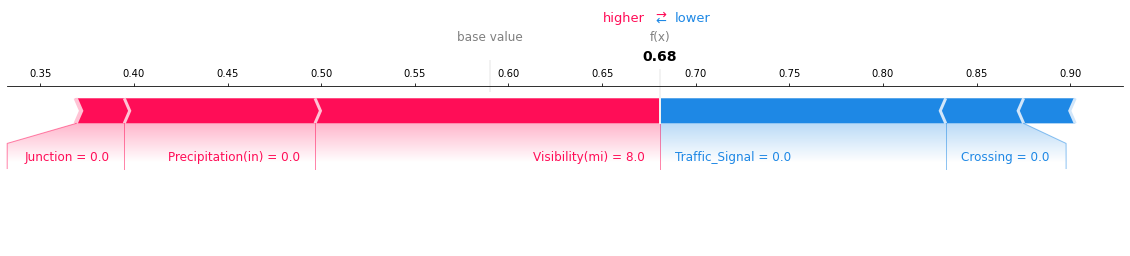

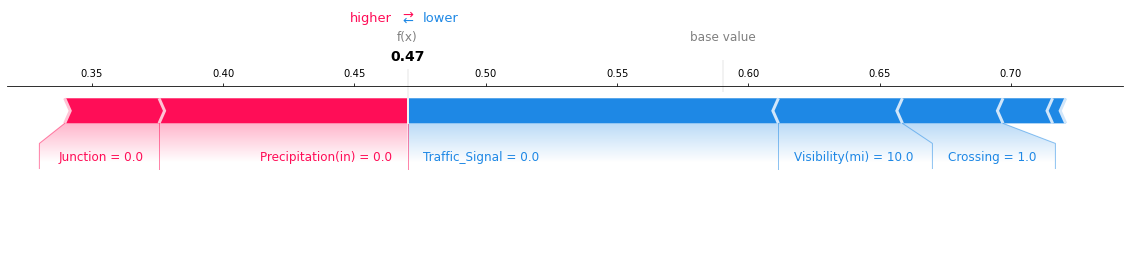

In [249]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test2.iloc[0,:], matplotlib=True)
shap.force_plot(explainer.expected_value[0], shap_values[0][1,:], X_test2.iloc[1041,:], matplotlib=True)

The two graphs just above are showing the impact of the variables on one instance of our dataset. Here, the first one and a random other one. In the graph below, we will have a better view of the variable's impact on every instance.

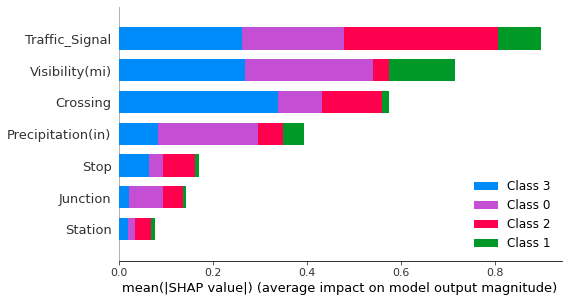

In [250]:
shap.summary_plot(shap_values, X_test2, plot_type="bar")

Here, we can see that the precipitation will have a great impact on every severity, and especially for the most severe accident (class 3). And for the number of traffic signals, we see that it has a big impact on the light accident (class 1 and class 2).

Compared to the linear regression, it comforts us with the choice of Precipitation influencing the severity. But, we had a coefficient of -0.12 for the traffic signals, and here we can see that it has a certain impact on the severity of an accident. It's the same thing for the variables Crossing and Visiblity that didn't have much impact on the linear regression. 

Let's do the beeswarms plot, with a dataframe with the most important variables

In [251]:
important_variables = X_test2[['Precipitation(in)', 'Traffic_Signal', 'Crossing', 'Visibility(mi)']].copy()

# Ajout de la variable Severity
important_variables['Severity'] = y_test2.copy()

KeyboardInterrupt: 

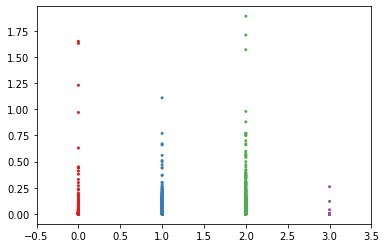

In [252]:
#plt.figure(figsize=(10, 6))

# Precipitation
sns.swarmplot(data=important_variables, x='Severity', y='Precipitation(in)', size=3, hue='Severity', palette='Set1')
plt.xlabel('Severity')
plt.ylabel('Precipitation(in)')
plt.title('Beeswarm Plot of Precipitation')
plt.show()

In [ ]:
# Traffic Signals
sns.swarmplot(x='Severity', y='Traffic_Signals', data=important_variables, size=2, hue='Severity', palette='Set1')
plt.xlabel('Severity')
plt.ylabel('Number of traffic signals')
plt.title('Beeswarm Plot for traffic signals')
plt.show()

In [ ]:
# Crossing
sns.swarmplot(x='Severity', y='Crossing', data=important_variables, size=3, hue='Severity', palette='Set1')
plt.xlabel('Severity')
plt.ylabel('Number of Crossing')
plt.title('Beeswarm Plot for Crossings')
plt.show()

# Question 7

In [253]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [254]:
shapley_values_array = np.array(shap_values)

# Reshape the array if necessary
shapley_values_2d = shapley_values_array.reshape(shapley_values_array.shape[0], -1)

# Perform PCA
pca = PCA(n_components=2)
shapley_pca = pca.fit_transform(shapley_values_2d)

In [255]:
# Perform K-Means clustering on the PCA values
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(shapley_pca)

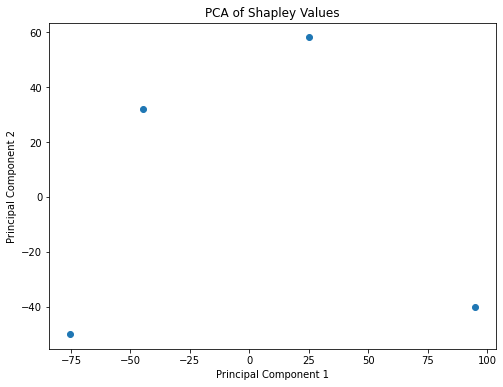

In [256]:
plt.figure(figsize=(8, 6))
plt.scatter(shapley_pca[:, 0], shapley_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Shapley Values')
plt.show()

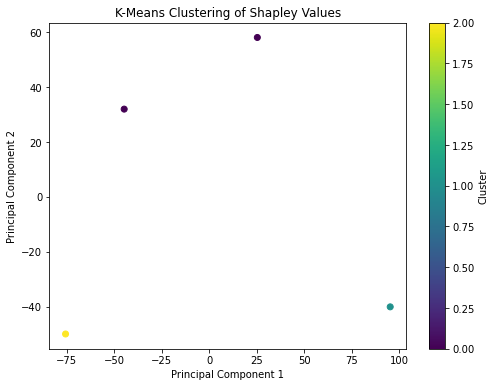

In [258]:
plt.figure(figsize=(8, 6))
plt.scatter(shapley_pca[:, 0], shapley_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Shapley Values')
plt.colorbar(label='Cluster')
plt.show()